In [51]:
import numpy as np
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt

In [2]:
# # import data
# logfile = open("../../../Data/Logs/light1_first_se_log.txt")
# # logfile = open("../../Data/Logs/Light1_OperationalTest_May6_ScriptLog_1.txt")
# loglines = logfile.readlines()
# print (loglines)

In [3]:
# for i in range(len(loglines)): # i is a number for every line in the log file
#     k = loglines[i] 
#     if "SE0>rtc read" in k:
#         I = i+1
#         l = loglines[I][14:]
#         print ("Line:" , i , ", Command:" , k , ", Time:" , l )

# # if the value is in range of the full range of file?
# # first rtc must be start of code, second rtc must be end of code

In [4]:
# for i in range(len(loglines)): # i is a number for every line in the log file
#     k = loglines[i] 
#     # l = loglines[i+1]
#     if k[0:12] in "SE0>rtc read":
#         # l=i+1
#         print ("line: " , i , ", command: " , k )




#     # if k[0:5] in "SE0>#":
#     #     print (k)

In [5]:
# Work to find the following:

# "Time,scenario"
# "At time () command () was excuted.
# "At time () command () failed."

# If line in SE0>:
# print the time
# print the command
# print the info
# print if command was excuted or failed

In [1]:
def desc_finder(line:str,cmdlist,outputs,i,time,failed_idx):

    # print(line)
    status = 1
    # id_in_graph = "none"
    splt = line.split(' ')

    # define end of log file
    if splt[-1] == 'SE0>':
        # desc = 'LOG END'
        desc = [-1,17]

    # define commands from the command file
    elif 'txrx' in splt[1]:
        node,port,msg = int(splt[2]),int(splt[3]),str(splt[5])

        index = cmdlist.loc[(cmdlist['NODE']==node) & (cmdlist['PORT']==port) & (cmdlist['Message'].str.startswith(msg)),['ID_COMMAND_Proposed','ID_in_Graph']]
        
        # include the power shutdown
        if node == 4:
            index = cmdlist.loc[(cmdlist['NODE']==node) & (cmdlist['PORT']==port),['ID_COMMAND_Proposed','ID_in_Graph']]

        # include the custom scenario
        if port == 9:
            index = cmdlist.loc[(cmdlist['NODE']==node) & (cmdlist['PORT']==port),['ID_COMMAND_Proposed','ID_in_Graph']]
        

        #If index did not find anything
        if len(index) == 0:
            # desc = ('Not Payload Command: '+ line)
            desc = []
            
        # if command found in command list
        else:
            desc = list(index.to_numpy()[0])
        

        if i in [fid for fid in failed_idx]:
            time = time + (float(splt[4])/1000)
            status = -1
        

    elif splt[1] == 'delay':
        # desc = 'Delay of: ' + splt[2] + 'ms'
        time = time + (float(splt[2])/1000)
        desc = []

    elif splt[1] == 'delayuntil':
        # desc = 'Delayuntil: ' + splt[2] + 's'
        time = float(splt[2])
        desc = []

    elif 'read' in splt[1]:
        t = outputs[i][0].split(' ')[3:-1]
        # desc = 'Read the Current Time: ' + ' '.join([str(elem) for elem in t])
        time = float(outputs[i][0].split(' ')[3])
        desc = []

    else:
        # desc = 'Different Command Type: ' + line
        desc = []
    
    return desc,time,status#,scenario

In [2]:
def decode_log(filename:str="../../../Data/Logs/light1-SD-1016-se-log.txt"):

    # Load the logfile
    logfile = open(filename)
    cmdlist = pd.read_csv("command_list.csv")

    # Load the lines
    loglines = logfile.readlines()

    # Close the file
    logfile.close()

    # Create an array with the lines
    commands    = []
    outputs     = []
    idx         = []
    description = []
    times       = []
    fails       = []
    failed_idx  = []
    IDs_in_Graph= [] 
    id_cmnds_proposed = []

    # Get commands and their indices
    for i, line in enumerate(loglines):
        if 'SE0>' in line:
            commands.append(line)
            idx.append(i)

    # Check if the last command was empty
    if loglines[-1] != 'SE0>':
        commands.append('SE0>')
        idx.append(len(loglines))

    # Get the command output
    for i in range(len(idx)-1):
        out = []
        if 'SE0>#' not in commands[i]:
            for j in range(idx[i]+1,idx[i+1]):
                out.append(loglines[j])
        
        outputs.append(out)

    # cmdid = dict(zip(idx, commands))

    # Create the dictionary
    log = [[command,output] for command,output in zip(commands,outputs)]

    # Check which commands executed correcly
  

    # Find the commands that failed
    for i in range(len(commands)-1):
        for output in log[i][1]:
            if 'FAIL' in output:
                failed_idx.append(i)


    # Initialize time at 0s
    time = 0
    
    # Give commands and use the finder function to pull the description, time ran, and if the command failed.
    for k, id in enumerate(idx):
        c = commands[k]
        cmd = c.split('\n')[0]
        desc,time,failed = desc_finder(cmd,cmdlist,outputs,k,time,failed_idx)
        # print (desc)
        # desc1=str(desc.replace('         ',','))
        # print (desc1)
        # print (type(desc1))
        # id_cmnd_proposed=desc1.split(',')[1]
        # print (id_cmnd_proposed)
        # id_cmnd_proposed=desc.split('         ')[0]
        # print (id_cmnd_proposed)
        # # # id_cmnd_proposed=88
        # id_in_graph=desc.split('         ')[1]
        # print (id_in_graph)
        # # id_in_graph=99

        # print(id_cmnd_proposed,id_in_graph)

        if len(desc) != 0:
            description.append(desc)
            times.append(time)
            fails.append(failed)
            # id_cmnds_proposed.append(id_cmnd_pdesc't exist
    tempname = 'templog.csv'
    fileDir = os.path.join('Defined_Logs')

    if not os.path.exists(fileDir):
        os.makedirs(fileDir)
    
    filePath = os.path.join(fileDir, tempname)

    #Name the headers of the CSV File
    header = ['status','time','description','ID_in_Graph']

    loglines_array = []

    #Clear the file and write from scratch
    with open(filePath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)

        for i in range(len(description)):
            g = (fails[i], times[i-1], description[i][0],description[i][1])#,id_cmnd_proposed[i],IDs_in_Graph[i])
            loglines_array.append(g)
            writer.writerow(g)



    # Create a dictionary
    return log, commands[:-1], outputs, description, failed_idx, loglines_array

In [5]:
# Get the log file and the commands
log, commands, outputs, description, failed_idx, loglines_array  = decode_log()

In [6]:
loglines_array

[(1, 1655804685.000885, 33, 16),
 (1, 1655723775.000854, 33, 16),
 (1, 1655723795.000854, 33, 16),
 (1, 1655723800.000854, 33, 16),
 (1, 1655726435.0, 33, 16),
 (1, 1655726435.0, 33, 16),
 (1, 1655726435.0, 33, 16),
 (1, 1655726435.017242, 33, 16),
 (1, 1655726436.017242, 33, 16),
 (1, 1655726437.017242, 25, 11),
 (-1, 1655726633.021881, 26, 11),
 (1, 1655726646.021881, 25, 11),
 (1, 1655726656.021881, 26, 11),
 (1, 1655726666.021881, 27, 12),
 (1, 1655726706.024506, 28, 12),
 (1, 1655726716.024506, 27, 12),
 (1, 1655726726.024506, 28, 12),
 (1, 1655726736.024506, 9, 8),
 (1, 1655726796.027985, 13, 1),
 (1, 1655726801.027985, 9, 8),
 (1, 1655726806.027985, 13, 1),
 (1, 1655726811.027985, 1, 0),
 (-1, 1655726831.031708, 12, 0),
 (1, 1655726844.031708, 1, 0),
 (1, 1655726854.031708, 12, 0),
 (1, 1655726864.031708, 23, 14),
 (1, 1655727047.487946, 24, 14),
 (1, 1655727057.487946, 23, 14),
 (1, 1655727097.487946, 24, 14),
 (1, 1655727107.487946, 33, 16),
 (1, 1655729175.007141, 33, 16),
 (

In [ ]:
# -------------------------------------------------------------------

In [7]:
# new from log_decoder_dev
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt

# Parse a command
def desc_finder(line:str,cmdlist,outputs,i,time,failed_idx):
    """Parse a command and return its status and description

    Args:
        line (str): The string of the command
        cmdlist (pd.DataFrame): pandas data frame with the commands and their equivalent messages
        outputs (_type_): _description_
        i (_type_): _description_
        time (_type_): _description_
        failed_idx (_type_): _description_

    Returns:
        _type_: _description_
    """

    # Get the description
    status = 1
    splt = line.split(' ')

    # define end of log file
    if splt[-1] == 'SE0>':
        # desc = 'LOG END'
        desc = [-1,17]
        text = "LOG END"

    # define commands from the command file
    elif 'txrx' in splt[1]:
        node,port,msg = int(splt[2]),int(splt[3]),str(splt[5])

        index = cmdlist.loc[(cmdlist['NODE']==node) & (cmdlist['PORT']==port) & (cmdlist['Message'].str.startswith(msg)),['ID_COMMAND_Proposed','ID_in_Graph']]
        
        # include the power shutdown
        if node == 4:
            index = cmdlist.loc[(cmdlist['NODE']==node) & (cmdlist['PORT']==port),['ID_COMMAND_Proposed','ID_in_Graph']]

        # include the custom scenario
        if port == 9:
            index = cmdlist.loc[(cmdlist['NODE']==node) & (cmdlist['PORT']==port),['ID_COMMAND_Proposed','ID_in_Graph']]
        

        #If index did not find anything
        if len(index) == 0:
            desc = [] 
            text = "not a payload cmnd"
            
        # if command found in command list
        else:
            desc = list(index.to_numpy()[0])
            text = "cmnd found in list"
        

        if i in [fid for fid in failed_idx]:
            time = time + (float(splt[4])/1000)
            status = -1
        

    elif splt[1] == 'delay':
        time = time + (float(splt[2])/1000)
        desc = []
        text = "delay of"

    elif splt[1] == 'delayuntil':
        time = float(splt[2])
        desc = []
        text = "delay until"

    elif 'read' in splt[1]:
        time = float(outputs[i][0].split(' ')[3])
        desc = []
        text = "read the current time"

    else:
        desc = []
        text = "unidentified command"
    
    return desc,time,status,text

# Decode a logfile
def decode_log(filename:str="../../../Data/Logs/light1-1124v2-se-log.txt"):
    """Take a log file and parse its commands to uncover thier timestamps

    Args:
        filename (str, optional): The filepath and filename of the log file. Defaults to "../../../Data/Logs/light1-SD-1016-se-log.txt".

    Returns:
        _type_: Log, commands, outputs, description, failed_idx, loglines_array
    """

    # Load the logfile
    logfile = open(filename)
    cmdlist = pd.read_csv("command_list.csv")

    # Load the lines
    loglines = logfile.readlines()

    # Close the file
    logfile.close()

    # Create an array with the lines
    commands    = []
    outputs     = []
    idx         = []
    description = []
    times       = []
    fails       = []
    failed_idx  = []
    text_desc   = []

    # Get commands and their indices
    for i, line in enumerate(loglines):
        if 'SE0>' in line:
            commands.append(line)
            idx.append(i)

    # Check if the last command was empty
    if loglines[-1] != 'SE0>':
        commands.append('SE0>')
        idx.append(len(loglines))

    # Get the command output
    for i in range(len(idx)-1):
        out = []
        if 'SE0>#' not in commands[i]:
            for j in range(idx[i]+1,idx[i+1]):
                out.append(loglines[j])
        
        outputs.append(out)

    # Create the dictionary
    log = [[command,output] for command,output in zip(commands,outputs)]

    # Check which commands executed correcly
  

    # Find the commands that failed
    for i in range(len(commands)-1):
        for output in log[i][1]:
            if 'FAIL' in output:
                failed_idx.append(i)


    # Initialize time at 0s
    time = 0
    
    # Give commands and use the finder function to pull the description, time ran, and if the command failed.
    for k, id in enumerate(idx):
        c = commands[k]
        cmd = c.split('\n')[0]
        desc,time,failed,text = desc_finder(cmd,cmdlist,outputs,k,time,failed_idx)

        if len(desc) != 0:
            description.append(desc)
            times.append(time)
            fails.append(failed)
            text_desc.append(text)
    tempname = 'templog.csv'
    fileDir = os.path.join('Defined_Logs')

    if not os.path.exists(fileDir):
        os.makedirs(fileDir)
    
    filePath = os.path.join(fileDir, tempname)

    #Name the headers of the CSV File
    header = ['status','time','description','ID_in_Graph']

    loglines_array = []

    #Clear the file and write from scratch
    with open(filePath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)

        for i in range(len(description)):
            g = (fails[i], times[i], description[i][0],description[i][1])#,text_desc[i])
            loglines_array.append(g)
            writer.writerow(g)

    # Return everything else
    return log, commands[:-1], outputs, description, failed_idx, loglines_array



In [8]:
log, commands, outputs, description, failed_idx, loglines_array = decode_log()

In [16]:
 loglines_array

[(1, 1657859400.0, 33, 16),
 (1, 1657859400.0, 33, 16),
 (1, 1657859400.0, 33, 16),
 (1, 1657859400.01059, 33, 16),
 (1, 1657859401.01059, 33, 16),
 (1, 1657859402.01059, 33, 16),
 (1, 1657859592.033844, 25, 11),
 (1, 1657859602.033844, 26, 11),
 (1, 1657859612.033844, 25, 11),
 (1, 1657859622.033844, 26, 11),
 (1, 1657859661.980255, 27, 12),
 (1, 1657859671.980255, 28, 12),
 (1, 1657859681.980255, 27, 12),
 (1, 1657859691.980255, 28, 12),
 (1, 1657859751.984924, 9, 8),
 (1, 1657859752.984924, 13, 1),
 (1, 1657859753.984924, 9, 8),
 (1, 1657859754.984924, 13, 1),
 (1, 1657859814.98941, 1, 0),
 (-1, 1657859827.98941, 12, 0),
 (1, 1657859837.98941, 1, 0),
 (1, 1657859847.98941, 12, 0),
 (1, 1657859911.493225, 23, 14),
 (1, 1657859921.493225, 24, 14),
 (1, 1657859961.493225, 23, 14),
 (1, 1657859971.493225, 24, 14),
 (1, 1657862143.003204, 33, 16),
 (1, 1657862163.003204, 33, 16),
 (1, 1657862168.003204, 33, 16),
 (1, 1657864800.0, 33, 16),
 (1, 1657864800.0, 33, 16),
 (1, 1657864800.0, 3

In [57]:
# function to grab the scenario from timestamp
def scenario_splitter(filename):
    log, commands, outputs, description, failed_idx, loglines_array = decode_log()
    
    # Identifiers of commands from the command list document:
    pmt_cmnds_lst = [1,2,3,4,5,6,7,8,9,10,11,23,25,27,29,31]
    sipm_cmnds_lst = [12,13,14,15,16,17,18,19,20,21,22,24,26,28,30,32]
    
    # Split commands for each detector:
    pmt_x,pmt_y,sipm_x,sipm_y=[],[],[],[]

    for logline in loglines_array:
        if logline[0] == 1:                 # looking only at the commands that did run, not the ones that failed
            # split commands based on which detector they were for:
            if logline[2] in pmt_cmnds_lst: 
                pmt_x.append(logline[1])
                pmt_y.append(logline[3])
            if logline[2] in sipm_cmnds_lst:
                sipm_x.append(logline[1])
                sipm_y.append(logline[3])
    
    
    return pmt_x,pmt_y,sipm_x,sipm_y


In [58]:
pmt_x,pmt_y,sipm_x,sipm_y = scenario_splitter(loglines_array)
# pmt_x

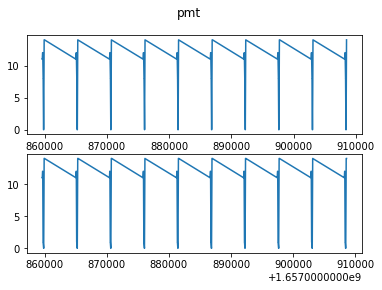

In [66]:
# plotting scenario graph:
fig, axs = plt.subplots(2)
axs[0].plot(pmt_x,pmt_y)
fig.suptitle("pmt")
axs[1].plot(sipm_x,sipm_y)

In [ ]:
# failed_idx

In [ ]:
# # Check which commands executed correcly
# failed_idx = []

# # Find the commands that failed
# for i in range(len(commands)):
#     for output in log[i][1]:
#         if 'FAIL' in output:
#             failed_idx.append(i)

# print(failed_idx)

In [ ]:
# print (failed_idx)
# print (failed_cmd,failed_output)
# print (failed_output)

In [ ]:
# Decode the file

In [ ]:
# Define the command description in a dict
# return timestamps of the scenarios and the failures (use the delays and the rtc reads to find the time)
# id,line,command,description,output(ok,or fail),timetaken
